# Jax・Brax・HaikuでGPU引きこもり学習
> 強化学習若手の会 Advent Calendar 2021 18日目

- toc: true 
- badges: true
- comments: true
- categories: [ja]

# 0. 時勢のあいさつとか

> Note: このブログは[強化学習若手の会 Advent Calendar 2021](https://adventar.org/calendars/6362) 18日目の記事として書かれました


こんにちは。
コロナ禍も終わりが見えつつある（と思ったらオミクロン株が...）2021年もあとわずか。寒さも厳しくなってきましたが、皆さん如何お過ごしでしょうか。
とは言ったものの、僕は沖縄にいるので、それほど寒くはないのですが...。

[若手の会](https://young-reinforcement.github.io/)のアドベントカレンダーということで、国内でのコミュニティの活動について、最初に総括してみたいと思います。

- 若手の会では模倣学習の勉強会をしましたが、結局2回しか続きませんでした。
- 苦手の会のもくもく会はフリスビーやマラソンの練習とバッティングしてやらなくなってしまいましたが、最近日程を変えて、火曜日の夜に始めました。暇な方一緒にもくもくしましょう。
- [強化学習の講義資料の翻訳](https://tadashik.github.io/rltheory-jp/)をしています。難しいですが、けっこう勉強になります。有限サンプルでのバウンドを、初めて勉強しました。興味がある方は、ぜひ一緒にやりましょう。
- 昨年の[ブログ](https://kngwyu.github.io/rlog/ja/2020/12/22/understanding-what-makes-rl-difficult.html)を書いてからはや一年、せっかく専用のブログを作ったので今年もいい感じに~~matplotlib芸~~強化学習の記事を書いていきたいと思っていましたが、結局何も書きませんでした。

最近は人工進化や人工生命の研究も始めたので、もはや「強化学習の人」と名乗っていいのかよくわかりませんが、今後も国内のコミュニティに何か貢献できればと思います。

今年は強化学習に対する楽観論も悲観論も多く目にした一年でした。
David SilverやSuttonは[Reward is Enough](https://www.sciencedirect.com/science/article/pii/S0004370221000862)という強気な論文を出し、知的なシステムはおよそ全て報酬最大化で作れると主張しました。
さすがに強気すぎると思いますが、その後[Reward is enough for convex MDPs](https://arxiv.org/abs/2106.00661)や[On the Expressivity of Markov Reward](https://openreview.net/forum?id=9DlCh34E1bN)といったテクニカルな論文が出てきたのは面白いです。
また、オフライン強化学習・教師なし強化学習の論文が増えてきたと思います。
ざっくり、**オフライン強化学習 = 強化学習 - 探索**、**教師なし強化学習 = 強化学習 - 報酬**と思ってもらって問題ないでしょう。
何を隠そう僕の修士論文も単なる「階層型強化学習」だったのですが、~~リジェクト~~諸般の事情により教師なしに魔改造して再投稿しました。
Sergey Levineにいたっては[Understanding the World Through Action](https://arxiv.org/abs/2110.12543)というタイトルが強い論文の中で、「大量にデータを集めてオフライン教師なし強化学習をすれば世界を理解できる（≒世界を理解しているのと同等のシステムが作れる？）」と言っています。面白い方向性だと思います。
一方で、みんな大好き[ルービックキューブ論文](https://openai.com/blog/solving-rubiks-cube/)を出したOpen AIのロボティクスチームは、「とりあえず今データがある領域に注力する」とのことで[解散](https://venturebeat.com/2021/07/16/openai-disbands-its-robotics-research-team/)してしまいました。
このブログを書いている最中に[WebGPT](https://openai.com/blog/improving-factual-accuracy/)の論文を目にしましたが、今後は言語モデル＋強化学習で色々やっていくのでしょうか。品川さんは喜びそうですが、僕なんかはこういう到底自分でできないものは「テレビの中の研究」という感じがして一歩引いてしまいます（最近は、テレビとかたとえに使うと古いのかな...）。
Open AIのロボティクスは、Sim2Realにこだわりすぎたのでは？という意見を某所でお聞きしました。実際そうなのかは知りませんが、大規模にシミュレーションしてSim2Realを頑張るのか、実機のデータで頑張るのかというのは、面白い視点ですよね。

Open AIが今までほど強化学習に注力しなくなったことで、[Open AI gym](https://gym.openai.com/)をはじめ強化学習研究で使われてきたソフトウェア群にも、色々と情勢の変化がありそうです。
1. [OpenAI Gymのメンテナが変わりました](https://github.com/openai/gym/issues/2259)。これからはOpen AIではなくメリーランド大学の学生さんがメンテナになるようです。mujoco-pyなど関連するライブラリについては相変わらず放置されています。
2. [DeepmindがMuJoCoを買い取って無料にしました](https://deepmind.com/blog/announcements/mujoco)。今後ソースコードも公開されるようです。
3. Googleから新しく[brax](https://github.com/google/brax)というシミュレータが公開されました。

そんなわけで、僕はこれまでmujoco-py + gymで作成した[カスタム環境](https://github.com/kngwyu/mujoco-maze/)でたくさん実験をやってきましたが、MuJoCoを使うにしてもdm_controlを使うとか、はたまたbraxにしてしまうとか、別の選択肢を検討したくなってきました。
このブログでは、とりあえずbraxを試してみようと思います。

# 1. はじめに: シミュレーション・謎ロボット・GPU

本題に入りますが、ざっくり、強化学習とは、**報酬**から**行動**を学習する枠組みだと言うことができます。
では**何の**行動を学習させたいのでしょうか。
ゲームのAIだったり、チャットボットだったり、色々な選択肢があると思いますが、どういうわけか**シミュレータ上で動く謎ロボット**というのがポピュラーな選択肢です。

このブログをごらんの方の中には、こういったナナフシのような謎ロボットの画像を目にしたことがある方も多いのではないでしょうか。

![HalfCheetah](https://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/HalfCheetah-v2/poster.jpg)

これはOpen AI gymのHalfCheetahというロボットです。足が2本なのでハーフなのだと思いますが、なんとも残酷なネーミングです。愛玩されるため病気のまま品種改良されてきた犬猫のような哀愁が漂います。

MuJoCoシミュレーターに「こことここがジョイントで、可動域はこうです。床は白黒でお願いします」みたいなXMLファイルを渡すと、こういうロボットを作ってくれます。
もしくは、[dm_control](https://github.com/deepmind/dm_control)などのPythonライブラリにXMLを作らせることもできます。
このような謎ロボットが実験で広く使われている要因として、
- みんなが使っているから
- Atariなどのゲームより高速
- ジョイントの速さ・位置などの完全な内部状態が手に入る
  - マルコフ性について心配しなくてもいい
- 色々カスタマイズできて便利だから
- 普通のロボットを訓練するためのテストにちょうどいいから

などの理由があると思いますが、なんだかんだみんなが使っているからというのが大きい気がします。

ところで、このMuJoCoシミュレータというのは非常に高速に動作するのですが、CPU上でしか動作しません。
今日使われている深層学習のコードは、その計算量のほとんどを占める行列演算がベクトル並列化ととても相性がいいため、ネットワークやバッチサイズが大きくなればなるほどGPU上で高速に動作します。
となると、GPUで学習を回している場合、どうしてもCPUからGPUにデータを転送するボトルネックが発生し、高速化の妨げになります。
そこで、GPU上でシミュレーションを行えるようにしたのが、今回紹介するbraxというシミュレータです。

# 2. Jaxでnumpy演算を高速化してみる

では、braxはCUDAか何かで書かれているのかな？と思ったかもしれませんが、なんと全てPythonで書かれているのです。
その鍵となるのが[jax](https://jax.readthedocs.io)というライブラリです。
おもむろに、インストールしてみましょう。

In [33]:
!pip install jax
!pip install celluloid

ドキュメントの冒頭に'JAX is Autograd and XLA'とありますが、Jaxは
- Numpy演算をXLAに変換するコンパイラ(Tensorflow)
  - `jax.jit`
  - [XLA](https://www.tensorflow.org/xla)はTensorflowのバックエンドとして開発された中間言語で、GPU/TPU用にすごく速いコードを生成できる
- Numpy演算を追跡して勾配を計算する機能
  - `jax.grad`/`jax.vjp` など

の2つのコア機能を核とするライブラリです。
この節では、ひとまず前者の「XLAに変換するコンパイラ」としての機能に焦点を当ててみます。

コンパイラは[JIT](https://ja.wikipedia.org/wiki/%E5%AE%9F%E8%A1%8C%E6%99%82%E3%82%B3%E3%83%B3%E3%83%91%E3%82%A4%E3%83%A9)方式で実装されており、
1. [`jax.jit`](https://jax.readthedocs.io/en/latest/jax.html#jax.jit)に関数`f`を渡す (`f_compiled = jax.jit(f)`）
2. コンパイルされる関数`f_compiled`を最初に呼び出したとき、jaxはPythonの関数をXLAにコンパイルする
3. 2回目以降関数呼び出しが高速になる
という処理の流れになります。

では、さっそく何かシミュレーションしてみましょう。
適当に天井からボールを落としてみましょう。

In [34]:
import typing as t

import numpy as np
from IPython.display import HTML, clear_output
try:
    import pandas as pd
    import seaborn as sns
    from celluloid import Camera
    from matplotlib import pyplot as plt
    from matplotlib.animation import ArtistAnimation
except ImportError as _e:
    ! pip isntall pandas seaborn celluloid
    clear_output()
    
    import pandas as pd
    import seaborn as sns
    from celluloid import Camera
    from matplotlib import pyplot as plt
    from matplotlib.animation import ArtistAnimation

sns.set_theme(style="darkgrid")

Array = np.ndarray
GRAVITY = -9.8


def move_balls(
    ball_positions: Array,
    ball_velocities: Array,
    delta_t: float = 0.1,
) -> Array:
    accel_x = np.zeros(ball_positions.shape[0])
    accel_y = np.ones(ball_positions.shape[0]) * GRAVITY * delta_t  # y方向にGΔt加速
    new_velocities = np.stack((accel_x, accel_y), axis=1) + ball_velocities
    new_positions = ball_positions + delta_t * new_velocities
    return new_positions, new_velocities


def simulate_balls(
    n_balls: int,
    n_steps: int = 100,
    forward: t.Callable[[Array], Array] = move_balls,
) -> t.List[Array]:
    p = np.random.uniform(size=(n_balls, 2), low=-50, high=50.0)
    v = np.random.randn(n_balls, 2)
    results = [p]
    for _ in range(n_steps):
        p, v = forward(p, v)
        results.append(p)
    return results

適当にボールを20個落としてみます。

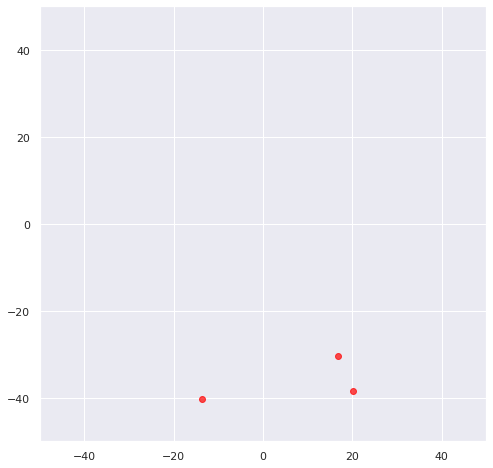

In [35]:
# collapse-hide

def ball_animation(balls: t.Iterable[Array]) -> ArtistAnimation:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
    camera = Camera(fig)
    for ball_batch in balls:
        ax.scatter(ball_batch[:, 0], ball_batch[:, 1], color="red", alpha=0.7)
        camera.snap()
    return camera.animate()


HTML(ball_animation(simulate_balls(20, 40)).to_jshtml())

では、このシミュレーションをするのに、どれくらい時間がかかるでしょうか。ボールの数を変えてベンチマークしてみましょう。

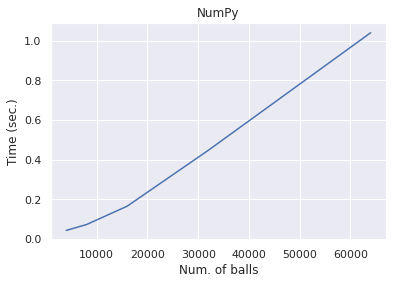

In [36]:
def bench(
    f: t.Callable[..., t.Any],
    inputs: t.Iterable[t.Any],
    number: int = 10,
) -> t.List[float]:
    import timeit

    return [timeit.Timer(lambda: f(x)).timeit(number=number) for x in inputs]


def bench_and_plot(f: t.Callable[..., t.Any], title: str) -> pd.DataFrame:
    inputs = [4000, 8000, 16000, 32000, 64000]
    result = pd.DataFrame({"x": inputs, "y": bench(f, inputs)})
    result["Method"] = [title] * len(inputs)
    ax = sns.lineplot(data=result, x="x", y="y")
    ax.set_title(title)
    ax.set_xlabel("Num. of balls")
    ax.set_ylabel("Time (sec.)")
    return result


numpy_result = bench_and_plot(simulate_balls, "NumPy")

おおむね線形に実行時間が増えていることがわかります。このコードを、jaxを使って高速化してみましょう。
基本的には`numpy`を`jax.numpy`に置き換えればいいです。

In [37]:
import jax
import jax.numpy as jnp

JaxArray = jnp.DeviceArray

def move_balls_jax(
    ball_positions: JaxArray,
    ball_velocities: JaxArray,
    delta_t: float = 0.1,
) -> JaxArray:
    accel_x = jnp.zeros(ball_positions.shape[0])
    accel_y = jnp.ones(ball_positions.shape[0]) * GRAVITY * delta_t
    new_velocities = jnp.stack((accel_x, accel_y), axis=1) + ball_velocities
    new_positions = ball_positions + delta_t * new_velocities
    return new_positions, new_velocities

では同じようにベンチマークをとってみましょう。

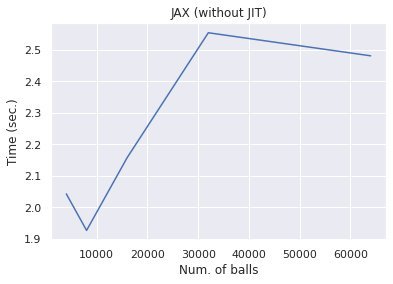

In [38]:
jax_nojit_result = bench_and_plot(
    lambda n: simulate_balls(n, forward=move_balls_jax),
    "JAX (without JIT)",
)

謎の挙動を見せているし、すごく遅いですね。今度はJITコンパイルしてみましょう。
`jax.jit(f, backend="cpu")`で関数をCPU上で動くXLAコードにコンパイルできます。

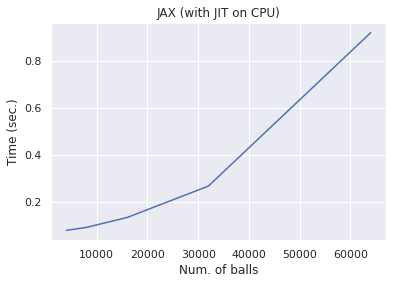

In [39]:
jax_cpu_result = bench_and_plot(
    lambda n: simulate_balls(n, forward=jax.jit(move_balls_jax, backend="cpu")),
    "JAX (with JIT on CPU)",
)

すごく速くなりました。今度はGPUでやってみます。

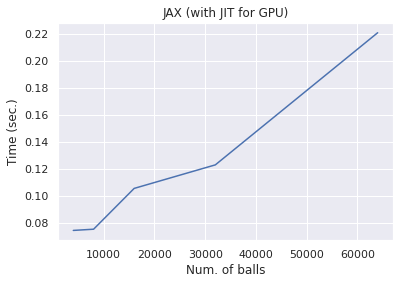

In [40]:
jax_gpu_result = bench_and_plot(
    lambda n: simulate_balls(n, forward=jax.jit(move_balls_jax, backend="gpu")),
    "JAX (with JIT for GPU)",
)

圧倒的に速いですね。一応線形に実行時間が増えてはいますが...。
なお、今回は学内スパコンのNVIDIA P100 GPUを使用しています。

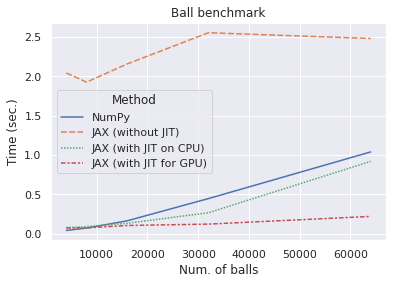

In [41]:
# collapse-hide
ax = sns.lineplot(
    data=pd.concat(
        [numpy_result, jax_nojit_result, jax_cpu_result, jax_gpu_result],
        ignore_index=True,
    ),
    x="x",
    y="y",
    style="Method",
    hue="Method",
)
ax.set_title("Ball benchmark")
ax.set_xlabel("Num. of balls")
ax.set_ylabel("Time (sec.)")
None

このボールの数だとGPUは線形に計算時間が増えているように見えませんね。
まあ何はともあれ、GPU用にJITコンパイルしてあげると速そうだなあ、という感じがします。

# 3. Jaxで勾配を計算してみる

Jaxは単に速いNumPyとしての機能に加え、自動微分によって、関数$f(x, y, z, ...)$の各$x, y, z,...$による偏微分$\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}, ...$を計算する機能を持っています。ここでは`jax.grad`による勾配の計算だけを紹介します。

なんか、適当に関数を最適化してみましょう。まずは、適当に関数を決めてみます。
$z = x^2 + y^2 + y$ にしました。

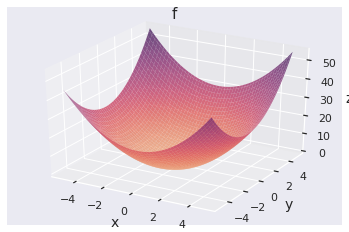

In [42]:
def f(x, y):
    return x ** 2 + y ** 2 + y


def plot_f(traj: t.Optional[Array] = None) -> None:
    x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(
        x,
        y,
        f(x, y),
        cmap=sns.color_palette("flare", as_cmap=True),
        alpha=0.8,
        linewidth=0,
    )
    if traj is not None:
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color="blue")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("y", fontsize=14)
    ax.set_zlabel("z", fontsize=14, horizontalalignment="right")
    ax.set_title("f", fontsize=15)


plot_f()

$(x, y) = (5, 5)$でのこの関数の勾配を計算してみます。勾配を計算してほしい引数を`jax.grad(argnums=...)`で指定します。

In [43]:
jax.grad(f, argnums=(0, 1))(jnp.array(5.0), jnp.array(5.0))

(DeviceArray(10., dtype=float32, weak_type=True),
 DeviceArray(11., dtype=float32, weak_type=True))

$\frac{\partial z}{\partial x}, \frac{\partial z}{\partial y}$を計算してくれました。
せっかくなので、最急降下法してみましょう。

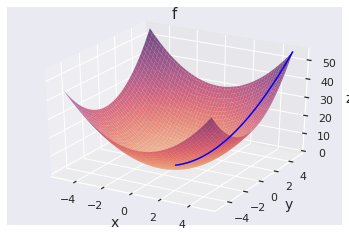

In [44]:
def steepest_descent(alpha: float = 0.01) -> JaxArray:
    f_grad = jax.grad(f, argnums=(0, 1))
    x, y = jnp.array(5.0), jnp.array(5.0)
    traj = []
    while True:
        traj.append((x, y, f(x, y)))
        x_grad, y_grad = f_grad(x, y)
        if jnp.linalg.norm(jnp.array([x_grad, y_grad])) < 0.05:
            break
        x -= alpha * x_grad
        y -= alpha * y_grad
    return jnp.array(traj)

plot_f(steepest_descent())

最急降下方向に進んでくれているように見えます。
ところで、gradはトップダウン型リバースモード自動微分（誤差逆伝播法の難しい言い方です）を採用しているので、リバースモードでVector Jacobian Productを計算する`vjp`という関数が使われています。
フォーワードモードで計算する`jvp`という関数もあります。
このあたりの機能は、ただネットワークを学習させたいだけならほとんど使いませんが、一応やってみましょう。

In [45]:
primals, f_vjp = jax.vjp(f, 5.0, 5.0)
print(f"VJP value: {primals.item()} grad: {[x.item() for x in f_vjp(1.0)]}")
value, grad = jax.jvp(f, (5.0, 5.0), (1.0, 1.0))
print(f"JVP value: {value.item()} grad: {grad.item()}")

VJP value: 55.0 grad: [10.0, 11.0]
JVP value: 55.0 grad: 21.0


フォーワードモードの場合勾配となんかのベクトルvとの内積がでてきます。
このあたり、色々な教科書に書いてあると思いますが、Forward modeとReverse modeの違いなど、[Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html)の13章が特にわかりやすいと思います。興味がある方は参考にしてみてください。

# 4. Braxを使ってみる

じゃあMuJoCoみたいな物理シミュレーターもJaxで書いてしまえば勝手にGPU上で動いて速いんじゃない？というモチベーションで作られたのが[brax](https://github.com/google/brax)です。
簡単に特徴をまとめてみます。

- Jaxで記述されているため、jitで高速化できる
- Protocol Bufferでシステムを定義 (cf. MuJoCoはXML）
- dataclass`QP`を使った簡潔な状態記述
  - Qは正準座標、Pは運動量らしい
- OpenAI gym風の`Env` APIやAnt・Halfcheetahなどの謎ロボット

おもむろにインストールしてみます。

In [46]:
try:
    import brax
except ImportError:
    !pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

さっきと同じ、ボールを動かしてみましょう。さっきはxy座標で動かしましたが、brax

/usr/local/lib/python3.7/dist-packages/brax/physics/base.py:192: UserWarning: dynamics_mode either not specified or not recognized, defaulting to "pbd".  If you wish to preserve legacy behavior used in previous versions of Brax, set dynamics_mode="legacy_spring".
  'dynamics_mode either not specified or not recognized, defaulting to '
/usr/local/lib/python3.7/dist-packages/brax/physics/integrators.py:63: RuntimeWarning: invalid value encountered in true_divide
  rot = rot / jp.norm(rot)


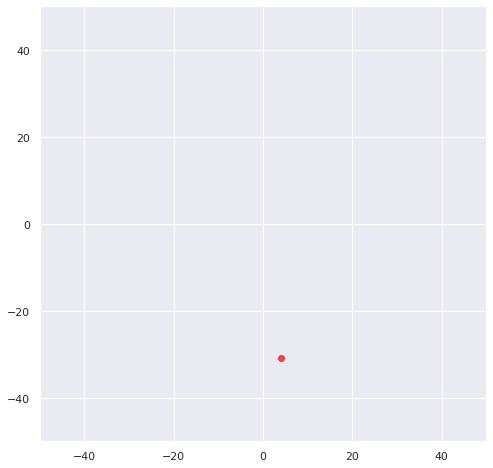

In [47]:
def make_ball() -> None:
    config = brax.Config(dt=0.1, substeps=4)
    # ボールを追加
    ball = config.bodies.add(name="ball", mass=1)
    capsule = ball.colliders.add().capsule
    capsule.radius = 0.5
    # y座標に重力
    config.gravity.y = GRAVITY
    return config


def make_qp(p, v) -> brax.QP:
    return brax.QP(
        pos=jnp.array([[p[0], p[1], 0.0]]),  # position
        vel=jnp.array([[v[0], v[1], 0.0]]),  # velocity
        rot=jnp.zeros((1, 4)),  # rotation
        ang=jnp.zeros((1, 3)),  # angular velocity
    )


def simulate_one_ball_brax(n_steps: int = 100) -> t.List[Array]:
    sys = brax.System(make_ball())
    qp = make_qp([0.0, 48.0], [1.0, 0.0])
    results = []
    for _ in range(n_steps):
        qp, _ = sys.step(qp, [])
        results.append(qp.pos[:2])
    return results


HTML(ball_animation(simulate_one_ball_brax(40)).to_jshtml())

ここで、4つのAPIを使いました。
- `brax.Config`でシステムを定義
- `brax.System(config)`でシステムを作成
- `brax.QP`で初期位置・速度・アングル等を作成
- `brax.System.step(qp, ...)`で1ステップシミュレーションした結果を取得

ボールが一つだとなんとなく物足りないですね。増やしてみましょう。そのためには、[`jax.vmap`](https://jax.readthedocs.io/en/latest/jax.html#vectorization-vmap)で`sys.step`をベクトル化します。
デフォルトで、vmapは引数のテンソルに対する演算を`axis=0`でバッチ化します。
このあたりは`in_axes=(1, 0, ...)`とかやれば調節できますが、今回はデフォルトでOKです。

`[make_qp(*pv) for pv in zip(p, v)]`で、`List[brax.QP]`を作っていますが、これを[`jax.tree_map`](https://jax.readthedocs.io/en/latest/_autosummary/jax.tree_util.tree_map.html#jax.tree_util.tree_map)でもう一回QPに戻しています。
```
List[QP(p=(0, 0), v(0, 0)), QP(..), ...] 
```
が
```
QP(
    p=[(0, 0), (0.1, 0.2),. ...], 
    v=[(0, 0), (1, 2), ...],
)
```
に変換される感じです。
このジャーゴンは便利なので覚えてもいいと思います。
ちなみに、treemapのノードが葉かどうかはオブジェクトが[PyTreeか否か](https://jax.readthedocs.io/en/latest/pytrees.html)によります。
これは「以上のデータ構造をJaxは暗に木構造だとみなします。不足なら自分で登録してください」という話なので、最初は面食らうと思います。
これを陽なAPIでやろうにするとRustやScalaにあるtraitが必要なので、悪い設計ではないと思いますが。
というわけで、コードはこんな感じになります。

/usr/local/lib/python3.7/dist-packages/brax/physics/base.py:192: UserWarning: dynamics_mode either not specified or not recognized, defaulting to "pbd".  If you wish to preserve legacy behavior used in previous versions of Brax, set dynamics_mode="legacy_spring".
  'dynamics_mode either not specified or not recognized, defaulting to '


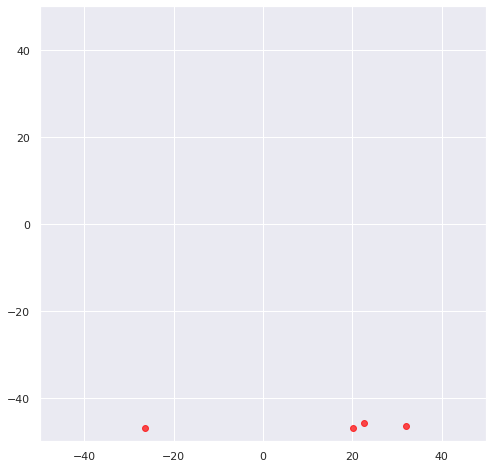

In [48]:
def simulate_balls_brax(n_balls: int, n_steps: int = 100) -> t.List[Array]:
    sys = brax.System(make_ball())
    p = np.random.uniform(size=(n_balls, 2), low=-50, high=50.0)
    v = np.random.randn(n_balls, 2)
    qps = [make_qp(*pv) for pv in zip(p, v)]
    qps = jax.tree_map(lambda *args: jnp.stack(args), *qps)
    # ここで
    step_vmap = jax.jit(jax.vmap(lambda qp: sys.step(qp, [])))
    results = []
    for _ in range(n_steps):
        qps, _ = step_vmap(qps)
        results.append(qps.pos[:, 0, :2])
    return results

HTML(ball_animation(simulate_balls_brax(20, 40)).to_jshtml())

jitを使わないとbraxがなぜかnumpyの関数を呼ぼうとしてエラーになったので、jitも併用しています。

# 5. Haikuで謎のロボットを学習させてみる

というわけで、braxの使い方をざっと見てみましたが、毎回自分でロボットを考えるのは大変~~だし査読者にも文句を言われる~~なので、今回は謎ロボットを学習させてみましょう。
open AI gym風の`brax.envs.Env`がサポートされています。今回はAntを訓練してみましょう。
`gym.make`に相当するのが`brax.envs.create`です。
`step`のAPIはgymと違い内部状態・報酬などが入った`brax.envs.State`というクラスを渡して次の`State`を受け取るというインターフェイスです。

In [49]:
import brax.envs


def render_html(sys: brax.System, qps: t.List[brax.QP]) -> HTML:
    import uuid
    import brax.io.html

    html = brax.io.html.render(sys, qps)
    # A weired trick to show multiple brax viewers...
    html = html.replace("brax-viewer", f"brax-viewer-{uuid.uuid4()}")
    return HTML(html)


def random_ant() -> HTML:
    env = brax.envs.create(env_name="ant")
    prng_key = jax.random.PRNGKey(0)
    state = env.reset(prng_key)
    qps = [state.qp]
    step_jit = jax.jit(env.step)
    for i in range(10):
        prng_key, action_key = jax.random.split(prng_key)
        action = jax.random.normal(action_key, shape=(env.action_size,))
        state = step_jit(state, action)
        qps.append(state.qp)
    return render_html(env.sys, qps)


random_ant()

なんか、跳ねていますね。嬉しそう。
では、さっそく学習させてみましょう。
今回は、深層強化学習の代表的な手法であるPPOを使ってみます。
本当はSACも用意したかったのですが、時間がなかったので諦めました。
とりあえず、三層MLPを用意しましょう。
例えば、こんな感じのものがあればいいです。

In [50]:
def mlp_v1(
    observation: JaxArray,
    w1: JaxArray,
    b1: JaxArray,
    w2: JaxArray,
    b2: JaxArray,
    w3: JaxArray,
    b3: JaxArray,
) -> JaxArray:
    x = jnp.dot(observation, w1) + b1
    x = jnp.tanh(x)
    x = jnp.dot(x, w2) + b2
    x = jnp.tanh(x)
    return jnp.dot(x, w3) + b3

これを`jit`して`grad`をとってAdamか何かでパラメタを更新して...とやればMLPが動くわけですが、パラメタが多すぎてちょっと面倒ですね。
そこでここでは、jaxでニューラルネットワークを訓練する際、パラメタの管理などをやってくれるライブラリである[Haiku](https://github.com/deepmind/dm-haiku)を使ってみます。
なお、brax公式のexamplesでは[Flax](https://github.com/google/flax)を使っています。
正直HaikuもFlaxもそこまで変わらないのですが、Flaxの方がややAPIの押しが強い（PyTorchでいう`nn.Module`相当のものがdataclassでないといけなかったりとか）印象があります。
また、HaikuはDeepmindが、FlaxはGoogleが開発しているライブラリとなります。
とりあえずインストールしてみましょう。

In [51]:
try:
    import haiku as hk
    import optax
    import chex
    import distrax
except ImportError as e:
    ! pip install git+https://github.com/deepmind/dm-haiku \
        git+https://github.com/deepmind/optax \
        git+https://github.com/deepmind/chex \
        git+https://github.com/deepmind/distrax
    
    import haiku as hk
    import optax
    import chex
    import distrax
    
    clear_output()

ニューラルネットワークを定義するためのPythonライブラリはtheano、tensorflowと色々ありましたが、最近は`torch.nn.Module`や`chainer.Link`のように、ネットワークの重み・forwardの出力・隣接しているノードを記録したオブジェクトを使って、動的に計算グラフを構築するものが多いかと思います。
しかし、Haikuによるそれは少し異なります。ポイントは、勾配を計算する部分はJaxが担当するので、Haikuはただ「ネットワークのパラメタを管理するだけ」でいいということです。
そのために、Haikuは`transform`というAPIを用意しています。
これは見たほうが早いでしょう。

In [52]:
def mlp_v2(observation: JaxArray) -> JaxArray:
    w1 = hk.get_parameter("w1", shape=[observation.shape[1], 3], init=jnp.ones)
    b1 = hk.get_parameter("b1", shape=[3], init=jnp.zeros)
    w2 = hk.get_parameter("w2", shape=[3, 3], init=jnp.ones)
    b2 = hk.get_parameter("b2", shape=[3], init=jnp.zeros)
    w3 = hk.get_parameter("w3", shape=[3, 2], init=jnp.ones)
    b3 = hk.get_parameter("b3", shape=[2], init=jnp.zeros)
    x = jnp.dot(observation, w1) + b1
    x = jnp.tanh(x)
    x = jnp.dot(x, w2) + b2
    x = jnp.tanh(x)
    return jnp.dot(x, w3) + b3

prng_seq = hk.PRNGSequence(0)  # これをグローバル変数にするのは良くないです。真似しないで
init, apply = hk.transform(mlp_v2)  # transformする
# initは乱数シード・インプットを受け取って、初期化したパラメタを返す関数
params = init(next(prng_seq), jnp.zeros((10, 2)))
print(params)
# applyはパラメタ・乱数シード・インプットを受け取って、出力を返す関数
output = apply(params, next(prng_seq), jnp.zeros((10, 2)))

{'~': {'w1': DeviceArray([[1., 1., 1.],
             [1., 1., 1.]], dtype=float32), 'b1': DeviceArray([0., 0., 0.], dtype=float32), 'w2': DeviceArray([[1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.]], dtype=float32), 'b2': DeviceArray([0., 0., 0.], dtype=float32), 'w3': DeviceArray([[1., 1.],
             [1., 1.],
             [1., 1.]], dtype=float32), 'b3': DeviceArray([0., 0.], dtype=float32)}}


こんな感じになります。
まとめると、
- `transform(f)`は二つの関数`init`、`apply`をかえす
- `transform`は`f`を、`f`の中で`haiku.get_parameter`を使って呼び出されたパラメタを入力とする関数に変換する
- `init`はパラメタを初期化して返す。パラメタは`FlatMap`というオブジェクトだがこれはほとんど`dict`と同じ
- `apply`は与えられたパラメタを使って所望の計算を行う
という感じですね。

ついでに、上の例では`hk.PRNGSequence`という`PRNGKey`の更新を勝手にやってくれるものを使っています。

しかし、これでもまだ面倒ですね。
実際のところ、よく使うネットワークはモジュールとしてまとまっているので、これを使えばいいです。

In [53]:
def mlp_v3(output_size: int, observation: JaxArray) -> JaxArray:
    x = hk.Linear(64)(observation)
    x = jnp.tanh(x)
    x = hk.Linear(64)(observation)
    x = jnp.tanh(x)
    return hk.Linear(output_size)(observation)

これを使って、PPOのネットワークを書いてみましょう。
方策は標準偏差が状態に依存しない正規分布にします。

In [54]:
class NetworkOutput(t.NamedTuple):
    mean: JaxArray
    stddev: JaxArray
    value: JaxArray


def policy_and_value(action_size: int, observation: JaxArray) -> NetworkOutput:
    mean = mlp_v3(output_size=action_size, observation=observation)
    value = mlp_v3(output_size=1, observation=observation)
    logstd = hk.get_parameter("logstd", (1, action_size), init=jnp.zeros)
    stddev = jnp.ones_like(mean) * jnp.exp(logstd + 1e-8)
    return NetworkOutput(mean, stddev, value)

これだけです。デフォルトでは、ネットワークの重みは[TruncatedNormal](https://dm-haiku.readthedocs.io/en/latest/api.html#haiku.initializers.TruncatedNormal)で初期化されます。今回は全部デフォルトのままにしました。

次に、これを使って、環境とインタラクトするコードを書いてみます。
いま、braxの利点を活かすために、
1. ネットワークから次のアクションをサンプルして
2. シミュレータで次の状態をシミュレート
という過程をすべて`jax.jit`の中でやるのが理想ですよね。

ですから、たとえばこんな感じにやればいいです。

In [55]:
Action = JaxArray


def make_step_function(
    env: brax.envs.Env,
) -> t.Tuple[t.Callable[..., t.Any], t.Callable[..., t.Any]]:
    def step(state: brax.envs.State) -> t.Tuple[brax.envs.State, NetworkOutput, Action]:
        out = policy_and_value(env.action_size, state.obs)
        policy = distrax.MultivariateNormalDiag(out.mean, out.stddev)
        action = policy.sample(seed=hk.next_rng_key())  # transformするとこれが使えます
        state = env.step(state, jnp.tanh(action))
        return state, out, action

    init, apply = hk.transform(step)
    return jax.jit(init), jax.jit(apply)

ここで、行動のサンプルには[`distrax`](https://github.com/deepmind/distrax)というライブラリを使いました。
平均値にノイズをいれるだけなので、ライブラリを使ってもあまり変わらないのですが...。
いま、各ジョイントに対して加える力が、それぞれ独立な正規分布からサンプリングされると仮定しているので、`MutliVariateNormDiag`(共分散行列が対角行列になる多変量正規分布）を使ってモデリングしています。
`distrax.Independent`と`distrax.Normal`を使っても同じことができます。
行動は一応tanhで$[-1, 1]$の範囲にならしています。

ちょっと試してみましょう。

In [56]:
ant = brax.envs.create(env_name="ant", batch_size=1)
init, step = make_step_function(ant)
initial_state = jax.jit(ant.reset)(next(prng_seq))
params = init(next(prng_seq), initial_state)
_next_state, out, action = step(params, next(prng_seq), initial_state)
# chexはテスト用のライブラリです
chex.assert_shape((out.mean, out.stddev, action), (1, ant.action_size))

というわけで無事に`step`をJITコンパイルして高速化できました。
`reset`はほとんど呼ばないので別にコンパイルしなくてもいいのですが、jitしないとbraxが`jnp.DeviceArray`のかわりにnumpyを使いたがって少し面倒なのでjitしています。

あとはPPOを実装していきますが、時間の都合で手短かにいきます。
まずは[GAE](https://arxiv.org/abs/1506.02438)ですね。
普通に書くと`jax.jit`が[ループアンローリング](https://ja.wikipedia.org/wiki/%E3%83%AB%E3%83%BC%E3%83%97%E5%B1%95%E9%96%8B)を行ってコンパイル時間が激遅になるので、[`jax.lax.fori_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html)という黒魔術を使います。
コンパイル時定数は`static_argnums`で指定します。
`vmap`で各ワーカー用に並列化します。

In [57]:
import functools

@functools.partial(jax.jit, static_argnums=2)
def gae(
    r_t: JaxArray,
    discount_t: JaxArray,
    lambda_: float,
    values: JaxArray,
) -> chex.Array:
    chex.assert_rank([r_t, values, discount_t], 1)
    chex.assert_type([r_t, values, discount_t], float)
    lambda_ = jnp.ones_like(discount_t) * lambda_
    delta_t = r_t + discount_t * values[1:] - values[:-1]
    n = delta_t.shape[0]

    def update(i: int, advantage_t: JaxArray) -> JaxArray:
        t_ = n - i - 1
        adv_t = delta_t[t_] + lambda_[t_] * discount_t[t_] * advantage_t[t_ + 1]
        # return jax.ops.index_update(advantage_t, t_, adv_t)
        return advantage_t.at[t_].set(adv_t)

    advantage_t = jax.lax.fori_loop(0, n, update, jnp.zeros(n + 1))
    return advantage_t[:-1]


batched_gae = jax.vmap(gae, in_axes=(1, 1, None, 1), out_axes=1)

なんかブログで書くには黒魔術すぎる気もしますが...。

次に学習データのバッチを構成する部分ですね。
これは、普通にPyTorchとかと変わらないです。

In [58]:
import dataclasses


@chex.dataclass
class RolloutResult:
    """
    Required experiences for PPO.
    """

    observations: t.List[JaxArray]
    actions: t.List[JaxArray] = dataclasses.field(default_factory=list)
    rewards: t.List[JaxArray] = dataclasses.field(default_factory=list)
    terminals: t.List[JaxArray] = dataclasses.field(default_factory=list)
    outputs: t.List[NetworkOutput] = dataclasses.field(default_factory=list)

    def append(
        self,
        *,
        observation: JaxArray,
        action: JaxArray,
        reward: JaxArray,
        output: NetworkOutput,
        terminal: JaxArray,
    ) -> None:
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        self.outputs.append(output)
        self.terminals.append(terminal)

    def clear(self) -> None:
        self.observations = [self.observations[-1]]
        self.actions.clear()
        self.rewards.clear()
        self.outputs.clear()
        self.terminals.clear()


class Batch(t.NamedTuple):
    """Batch for PPO, also used as minibatch by indexing."""

    observation: JaxArray
    action: JaxArray
    reward: JaxArray
    advantage: JaxArray
    value_target: JaxArray
    log_prob: JaxArray

    def __getitem__(self, idx: Array) -> "Batch":
        return self.__class__(
            observation=self.observation[idx],
            action=self.action[idx],
            reward=self.reward[idx],
            advantage=self.advantage[idx],
            value_target=self.value_target[idx],
            log_prob=self.log_prob[idx],
        )


@jax.jit
def make_batch(rollout: RolloutResult, next_value: JaxArray) -> Batch:
    action = jnp.concatenate(rollout.actions)
    mean, stddev, value = jax.tree_map(lambda *x: jnp.concatenate(x), *rollout.outputs)
    log_prob = distrax.MultivariateNormalDiag(mean, stddev).log_prob(action)
    reward = jnp.stack(rollout.rewards)
    mask = 1.0 - jnp.stack(rollout.terminals)
    value = jnp.concatenate(
        (value.reshape(reward.shape), next_value.reshape(1, -1)),
        axis=0,
    )
    advantage = batched_gae(reward, mask * 0.99, 0.95, value)
    value_target = advantage + value[:-1]
    return Batch(
        observation=jnp.concatenate(rollout.observations[:-1]),
        action=action,
        reward=jnp.ravel(reward),
        advantage=jnp.ravel(advantage),
        value_target=jnp.ravel(value_target),
        log_prob=log_prob,
    )

普通のdataclassesはjitできないので、`chex.dataclass`を使います。
さっき少しだけ触れましたが、`chex.dataclass`は作成したdataclassをPyTreeとしてjaxに登録してくれます。
実は`flax.struct.dataclass`というだいたい同じものもあって、braxの内部ではこれを使っているようです。
また$\gamma = 0.99, \lambda = 0.95$としました。

いよいよ学習の部分ですね。
まず、損失関数を`jax.grad`できるように書きます。

In [59]:
def ppo_loss(action_size: int, batch: Batch) -> JaxArray:
    mean, stddev, value = policy_and_value(action_size, batch.observation)
    # Policy loss
    policy = distrax.MultivariateNormalDiag(mean, stddev)
    log_prob = policy.log_prob(batch.action)
    prob_ratio = jnp.exp(log_prob - batch.log_prob)
    clipped_ratio = jnp.clip(prob_ratio, 0.8, 1.2)
    clipped_obj = jnp.fmin(prob_ratio * batch.advantage, clipped_ratio * batch.advantage)
    policy_loss = -jnp.mean(clipped_obj)
    # Value loss
    value_loss = jnp.mean(0.5 * (value - batch.value_target) ** 2)
    # Entropy regularization
    entropy_mean = jnp.mean(policy.entropy(), axis=-1)
    return policy_loss + value_loss - 0.001 * entropy_mean

$\epsilon = 0.2$で固定しているので、$[1 - 0.2, 1 + 0.2]$の範囲でクリップします。

ではこれを使って、今度はパラメタの更新を全部jitにつっこんでみましょう。
パラメタの更新には[optax](https://github.com/deepmind/optax)というライブラリを使います。色々なSGDのバリアントを実装しているライブラリですが、僕はほとんどAdamしか使いません...。

In [60]:
import optax


def make_update_function(
    action_size: int,
    opt_update: optax.TransformUpdateFn,
) -> t.Callable[..., t.Any]:
    # hk.Paramsを使い回すのでinitは捨てていい
    # 行動をサンプルしないので、without_apply_rngが使える
    _, loss_fn = hk.without_apply_rng(hk.transform(lambda batch: ppo_loss(action_size, batch)))
    grad_fn = jax.grad(loss_fn)

    # ここでjitしていい
    @jax.jit
    def update(
        params: hk.Params,
        opt_state: optax.OptState,
        batch: Batch,
    ) -> t.Tuple[hk.Params, Batch]:
        grad = grad_fn(params, batch)
        updates, new_opt_state = opt_update(grad, opt_state)
        return optax.apply_updates(params, updates), new_opt_state

    return update

さて、ここまで来たらあと一歩ですね。
次に面倒ですが次の状態のvalueをとってきてバッチを作る部分を書きます。

In [61]:
def make_next_value_function(action_size: int) -> Batch:
    def next_value_fn(obs: JaxArray) -> JaxArray:
        output = policy_and_value(action_size, obs)
        return output.value

    _, next_value_fn = hk.without_apply_rng(hk.transform(next_value_fn))
    return jax.jit(next_value_fn)

速度を求めるなら、これは`make_batch`と一緒にjitしてしまってもいいですが、まあ面倒なのでこれでもいいでしょう。

では材料がそろったのでメインループを書いていきましょう。
面倒ですが、評価用のenvironmentも別に作ります。

In [62]:
try:
    import tqdm
except ImportError as _e:
    ! pip install tqdm
    import tqdm
    clear_output()

In [63]:
import datetime
from tqdm.notebook import trange


def sample_minibatch_indices(
    n_instances: int,
    n_minibatches: int,
    prng_key: chex.PRNGKey,
) -> t.Iterable[JaxArray]:
    indices = jax.random.permutation(prng_key, n_instances)
    minibatch_size = n_instances // n_minibatches
    for start in range(0, n_instances, minibatch_size):
        yield indices[start : start + minibatch_size]


def train_ppo(
    env_name: str = "ant",
    n_workers: int = 32,
    n_steps: int = 2048,
    n_training_steps: int = 50000,
    n_optim_epochs: int = 10,
    n_minibatches: int = 64,
    eval_freq: int = 20,
    eval_workers: int = 16,
    seed: int = 0,
) -> HTML:
    # 環境と、環境を含んだstep関数を作る
    env = brax.envs.create(env_name=env_name, episode_length=1000, batch_size=n_workers)
    eval_env = brax.envs.create(
        env_name=env_name,
        episode_length=1000,
        batch_size=eval_workers,
    )
    network_init, step = make_step_function(env)
    _, eval_step = make_step_function(eval_env)
    eval_reset = jax.jit(eval_env.reset)
    # 乱数
    prng_seq = hk.PRNGSequence(seed)
    # 初期状態
    state = jax.jit(env.reset)(rng=next(prng_seq))
    rollout = RolloutResult(observations=[state.obs])
    # Optimizerとパラメタを初期化する
    optim = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(3e-4, eps=1e-4))
    update = make_update_function(env.action_size, optim.update)
    params = network_init(next(prng_seq), state)
    opt_state = optim.init(params)
    # next_value
    next_value_fn = make_next_value_function(env.action_size)
    n_instances = n_workers * n_steps

    def evaluate(step: int) -> None:
        eval_state = eval_reset(rng=next(prng_seq))
        return_ = jnp.zeros(eval_workers)
        done = jnp.zeros(eval_workers, dtype=bool)
        for _ in range(1000):
            eval_state, _, _ = eval_step(params, next(prng_seq), eval_state)
            return_ = return_ + eval_state.reward * (1.0 - done)
            done = jnp.bitwise_or(done, eval_state.done.astype(bool))
        print(f"Step: {step} Avg. ret: {jnp.mean(return_).item()}")

    for i in trange(n_training_steps // n_instances):
        for _ in range(n_steps):
            state, output, action = step(params, next(prng_seq), state)
            rollout.append(
                observation=state.obs,
                action=action,
                reward=state.reward,
                output=output,
                terminal=state.done,
            )
        next_value = next_value_fn(params, state.obs)
        batch = make_batch(rollout, next_value)
        rollout.clear()
        # Batchを作ったので、ミニバッチサンプリングして学習
        for _ in range(n_optim_epochs):
            for idx in sample_minibatch_indices(
                n_instances,
                n_minibatches,
                next(prng_seq),
            ):
                minibatch = batch[idx]
                params, opt_state = update(params, opt_state, minibatch)

        # 時々評価する
        if (i + 1) % eval_freq == 0:
            evaluate(i + 1)
        

    # Visualize
    eval_state = eval_reset(rng=next(prng_seq))
    qps = []
    while eval_state.done[0] == 0.0:
        eval_state, _, _ = eval_step(params, next(prng_seq), eval_state)
        qps.append(jax.tree_map(lambda qp: qp[0], eval_state.qp))
    return render_html(eval_env.sys, qps)


start_time = datetime.datetime.now()
html = train_ppo()
elapsed = datetime.datetime.now() - start_time
print(f"Train completed after {elapsed.total_seconds() / 60:.2f} min.")
html

0it [00:00, ?it/s]

Train completed after 0.76 min.


100万ステップの訓練が41分で終わりました。速いですねやっぱり。
なんか前に跳ねすぎている微妙なのがビジュアライズされていますが...。

# 6. まとめ

というわけで、このブログではJax、Brax、Haikuを使って、GPUだけでシミュレータ上のロボットを訓練する例を示しました。
かなり駆け足の解説になりましたが、なんとなくプログラムの組み方を理解していただけたのではないかと思います。

総括すると、Jaxはかなり広い範囲のNumPy演算をGPU/TPU上で高速に動作するコードに変換できる、非常に強力なライブラリです。
今回紹介した`vmap`は、例えば一つのGPU上で演算を並列化する機能ですが、他にも`pmap`によるデバイスをまたいだ並列化もできます。
ですから特に、
- ✔ CPUとGPUの通信オーバーヘッドが気になるとき
- ✔ 大規模に並列なシミュレーションを行いたいとき

は、Jaxが効果を発揮すると思います。また、`jax.lax.fori_loop`を使って
- ✔ CythonやC++/Rustなど他の言語を使わずにPythonのループを高速化したいとき

にも使えます。
一方で、単に深層学習を高速化したい場合、例えば
- 🔺 PyTorchモデルの訓練がボトルネックになっている場合

などは、JaxやHaiku/Flaxを使うことによる高速化の恩恵はあまりないと思います。
うまくJitを使えばJaxの方が速いと思いますが、PyTorchのCUDAコードはかなり速いですからね。また、PyTorchと比較した際、
- 🔺 学習コストについてもJaxの方が大きい

のではないかと思います。
なので、個人的には学習以外の部分でベクトル並列化・Jitコンパイルによる並列化の余地がある場合に、Jaxは便利に使えるのかなあと思います。
ただDeepmindはAlphaFold2を始め、多くのJax+Haiku製深層学習コードをリリースしていますし、一応読める程度に親しんでおくだけでもある程度のメリットはあると思います。

さて、冒頭の**大規模にシミュレーションしてSim2Realを頑張るのか、実機のデータで頑張るのか**という話に戻りますが、シミュレーションをスケールさせたいのであれば大規模にシミュレーションしたいならBraxのように「シミュレーターをJaxでコンパイルできるように作る」というアプローチは面白いと思います。分子動力学計算など、物理演算以外のシミュレーションへの活用も期待されます（と聞いたことがあります。僕は分子動力学計算が何なのかよくわかりません...）。
一方で、シミュレータが微分可能であるという利点をどう活かすのかも興味深いテーマです。僕も以前PFNさんのインターンで、報酬が微分可能なシミュレータを使って、$\sum_{t = 0}^T\frac{\partial r_t}{\partial \theta}$についての山登り法で方策を更新するのを[試した](https://tech.preferred.jp/ja/blog/differentiable-simulator/)ことがあるのですが、報酬が遠いとなかなか難しいなあという印象でした。うまい方法があればいいのですが...。意外と勾配降下だけでなく進化計算などのメタヒューリスティクスと組み合わせると面白いかもしれないです。

さて、僕はもう一つアドベントカレンダーの記事を書く予定があったのですが、時間がないので他の人に代わってもらうかもしれません...。出たらそちらもよろしくお願いします。